In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
current_path = rf"/content/drive/My Drive/ProjectX/mini_projects"

Mounted at /content/drive


In [ ]:
class NN:
  def __init__(self,layer_dims):
    self.layer_dims = layer_dims
    self.parameters = None
    self.initialize_parameters()
    self.all_costs = []

  def initialize_parameters(self):
    self.parameters = {}
    L = len(self.layer_dims)
    for i in range(1,L):
      self.parameters["W" + str(i)] = np.random.randn(self.layer_dims[i],self.layer_dims[i-1]) * np.sqrt(2 / self.layer_dims[i-1])
      self.parameters["b" + str(i)] = np.zeros((self.layer_dims[i],1))

  def relu(self,Z):
    return np.maximum(0,Z)

  def relu_back(self,Z):
    return (Z > 0).astype(Z.dtype)

  def softmax(self,Z):
    Z_exp = np.exp(Z)
    return Z_exp / np.sum(Z_exp,axis=0,keepdims=True)

  def compute_cost(self,AL,Y):
    m = Y.shape[1]
    safe_AL = np.clip(AL,1e-10,1 - 1e-10)
    cost = (-1/m) * np.sum(Y * np.log(safe_AL))
    cost = np.squeeze(cost)
    return cost

  def forward_prop(self,X):
    caches = []
    L = len(self.layer_dims)
    A_prev = X
    for i in range(1,L-1):
      W = self.parameters["W" + str(i)]
      b = self.parameters["b" + str(i)]
      Z = (W @ A_prev) + b
      A = self.relu(Z)
      caches.append((A_prev,W,Z))
      A_prev = A

    W = self.parameters["W" + str(L-1)]
    b = self.parameters["b" + str(L-1)]
    Z = (W @ A_prev) + b
    AL = self.softmax(Z)
    caches.append((A_prev,W,Z))
    return AL,caches

  def backward_prop(self,AL,Y,caches):
    m = Y.shape[1]
    L = len(self.layer_dims)
    grads = {}

    A_prev,W,Z = caches[L-2]
    dZL = AL - Y
    dWL = (1 / m) * (dZL @ A_prev.T)
    dbL = (1 / m) * np.sum(dZL,axis=1,keepdims=True)
    dA_prev = W.T @ dZL
    grads["dW" + str(L-1)] = dWL
    grads["db" + str(L-1)] = dbL

    for i in reversed(range(1,L-1)):
      A_prev,W,Z = caches[i-1]
      dZ = dA_prev * self.relu_back(Z)
      dW = (1/m) * (dZ @ A_prev.T)
      db = (1/m) * np.sum(dZ,axis=1,keepdims=True)
      dA_prev = W.T @ dZ
      grads["dW" + str(i)] = dW
      grads["db" + str(i)] = db

    return grads

  def update_parameters(self,grads,lr):
    L = len(self.layer_dims)
    for i in range(1,L):
      self.parameters["W" + str(i)] -= lr * grads["dW" + str(i)]
      self.parameters["b" + str(i)] -= lr * grads["db" + str(i)]

  def train(self,X,Y,learning_rate=0.07,num_iterations=3000,print_cost=True):
    costs = []
    for i in range(num_iterations):
      AL,caches = self.forward_prop(X)
      cost  = self.compute_cost(AL,Y)
      grads = self.backward_prop(AL,Y,caches)
      self.update_parameters(grads,learning_rate)

      if print_cost and i % 100 == 0:
        print(f"Cost after {i} iterations : {cost}")
      if i % 100 == 0:
        costs.append(cost)
        self.all_costs.append(cost)
        self.store_params()
        self.store_costs()

    print(f"Final cost : {cost}")
    return costs

  def predict(self,X):
    AL,_ = self.forward_prop(X)
    return self.hardmax(AL)

  def hardmax(self,A):
    maxA = np.max(A,axis=0).reshape(1,A.shape[1])
    return (A >= maxA).astype('float')

  def getAccuracy(self,Y_pred,Y_test):
    pred_classes = np.argmax(Y_pred, axis=0)
    true_classes = np.argmax(Y_test, axis=0)
    return np.mean(pred_classes == true_classes)

  def plot_costs(self,costs):
    plt.figure(figsize=(8,6))
    plt.plot(costs)
    plt.title('Cost Function over Iterations')
    plt.xlabel('Iteration (per hundred)')
    plt.ylabel('Cost')
    plt.show()

  def store_params(self):
    params_copy = {}
    for key in self.parameters:
      params_copy[key] = self.parameters[key].tolist()
    with open(f"{current_path}/params.json",'w') as outfile:
      json.dump(params_copy,outfile)

  def store_costs(self):
    with open(f"{current_path}/costs.json",'w') as outfile:
      json.dump(self.all_costs,outfile)

In [ ]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [ ]:
m_train = train_X.shape[0]
m_test = test_X.shape[0]
print(f"Training examples : {m_train}")
print(f"Testing examples : {m_test}")

Training examples : 60000
Testing examples : 10000


In [ ]:
train_X_flatten = train_X.reshape(m_train,-1).T
test_X_flatten = test_X.reshape(m_test,-1).T

train_X_final = train_X_flatten / 255.
test_X_final = test_X_flatten / 255.

In [ ]:
train_Y_final = np.zeros((10,m_train),dtype='float')
test_Y_final = np.zeros((10,m_test),dtype='float')

for i in range(train_y.shape[0]):
  train_Y_final[train_y[i]][i] = 1.
for i in range(test_y.shape[0]):
  test_Y_final[test_y[i]][i] = 1.

In [ ]:
for i in range(5):
  print(f"{train_y[i]} : {train_Y_final[:,i]}")

5 : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
print(f"X_train shape : {train_X_final.shape}")
print(f"Y_train shape : {train_Y_final.shape}")
print(f"X_test shape : {test_X_final.shape}")
print(f"Y_test shape : {test_Y_final.shape}")


X_train shape : (784, 60000)
Y_train shape : (10, 60000)
X_test shape : (784, 10000)
Y_test shape : (10, 10000)


In [ ]:
layer_dims = [train_X_final.shape[0],128,64,10]
model = NN(layer_dims)

In [ ]:
model.train(train_X_final,train_Y_final,0.1,num_iterations=1000)

Cost after 0 iterations : 2.4605307017146334
Cost after 100 iterations : 0.39958193865527775
Cost after 200 iterations : 0.29818254386304804
Cost after 300 iterations : 0.2594221040718364
Cost after 400 iterations : 0.232010265669739
Cost after 500 iterations : 0.21065482023660895
Cost after 600 iterations : 0.1931859892398015
Cost after 700 iterations : 0.17858364396811574
Cost after 800 iterations : 0.1662458988346915
Cost after 900 iterations : 0.15563407916765085
Final cost : 0.14647865446247094


[2.4605307017146334,
 0.39958193865527775,
 0.29818254386304804,
 0.2594221040718364,
 0.232010265669739,
 0.21065482023660895,
 0.1931859892398015,
 0.17858364396811574,
 0.1662458988346915,
 0.15563407916765085]

In [ ]:
Y_pred = model.predict(test_X_final)
accuracy = model.getAccuracy(Y_pred,test_Y_final)
print(f"Test Accuracy : {accuracy}")

Test Accuracy : 0.9541


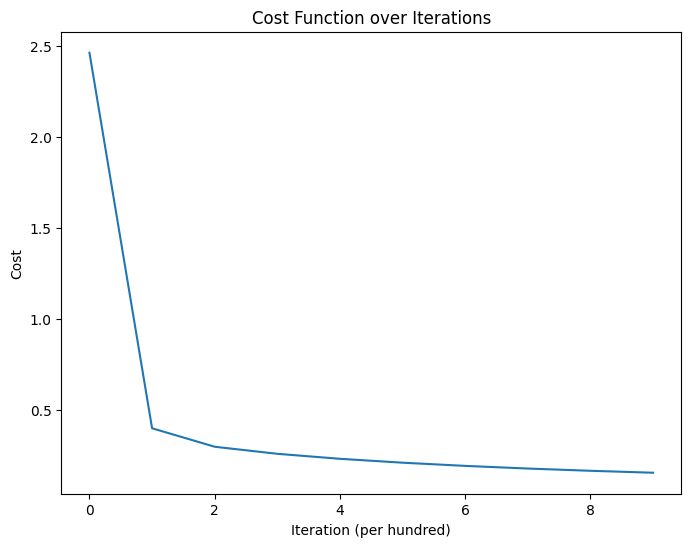

In [ ]:
model.plot_costs(model.all_costs)

Index : 5334
True value : 7
Predicted value : 7


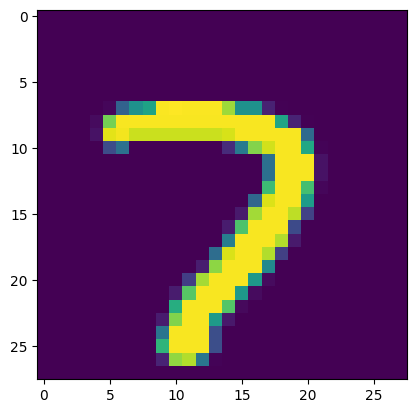

In [ ]:
index = np.random.randint(0,m_test)
print(f"Index : {index}")
print(f"True value : {test_y[index]}")
prediction_arr = model.predict(np.array([test_X_final[:,index]]).T)
prediction = np.argmax(prediction_arr)
print(f"Predicted value : {prediction}")
plt.imshow(test_X[index])
plt.show()